# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import plotly
import plotly.express as px


In [110]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > local_venv_requirements.txt

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

**Данные о клиентах банка**:

* **age** (возраст);
* **job** (сфера занятости);
* **marital** (семейное положение);
* **education** (уровень образования);
* **default** (имеется ли просроченный кредит);
* **housing** (имеется ли кредит на жильё);
* **loan** (имеется ли кредит на личные нужды);
* **balance** (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании**:

* **contact** (тип контакта с клиентом);
* **month** (месяц, в котором был последний контакт);
* **day** (день, в который был последний контакт);
* **duration** (продолжительность контакта в секундах).



**Прочие признаки**:

* **campaign** (количество контактов с этим клиентом в течение текущей кампании);
* **pdays** (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* **previous** (количество контактов до текущей кампании)
* **poutcome** (результат прошлой маркетинговой кампании)

**Целевая переменная**: 

* **deposit** которая определяет, согласится ли клиент открыть депозит в банке.

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')
print(df.shape)
df.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Мы видим, что dtypes: int64(6), object(11)


In [4]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Есть явные пропуски, не большое колличество balance (25)

### Задание 2

In [5]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

В не явном выражение пропуски заполнены словом "unknown"

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: x if [x]==[np.nan] else float((x.replace(' ', '')).replace(',', '.').split('$')[0]))

In [7]:
round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [8]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [9]:
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x=='unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x=='unknown' else x)

In [11]:
df_copy =df[(df.job == 'management')& (df.education == 'secondary')]
print(round(df_copy['balance'].mean(),3))

1598.883


### Задание 6

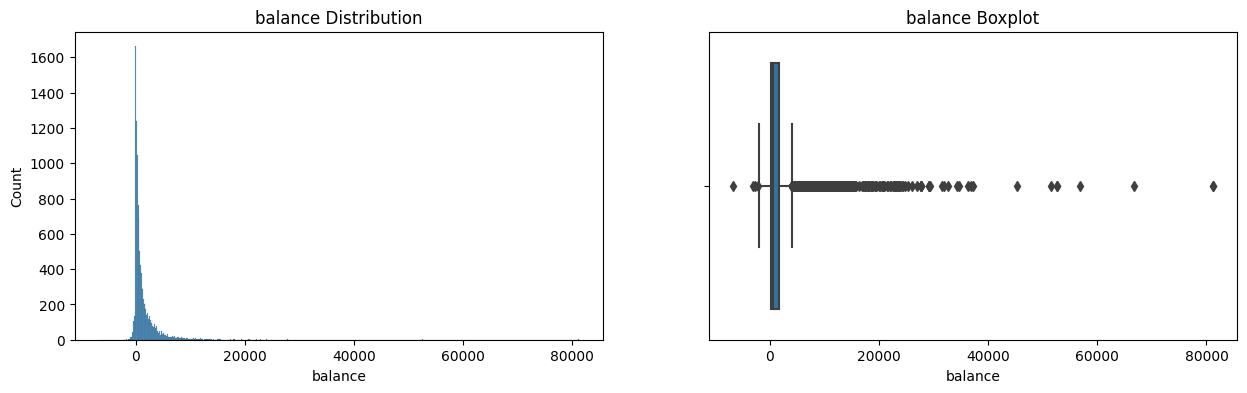

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('balance Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('balance Boxplot');

In [13]:
# удалите все выбросы для признака balance методом межквартильного размаха (Тьюки)
def outliers_iqr_mod_log(data, feature, log_scale=False, left=1.5, right=1.5, add_one=False): 
    if log_scale and add_one:
        x = np.log(df[feature]+1)
    elif log_scale and not add_one:
        x = np.log(df[feature])
    else:
        x = df[feature]
        
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x> upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)].reset_index().drop('index', axis=1)
    
    return outliers, cleaned, lower_bound, upper_bound




In [14]:
outliers, cleaned, lower_bound, upper_bound = outliers_iqr_mod_log(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(round(lower_bound), round(upper_bound))

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
-2241 4063


In [15]:
df = cleaned
df.shape[0]

10105

## Часть 2:  Разведывательный анализ

### Задание 1

<AxesSubplot: xlabel='deposit', ylabel='count'>

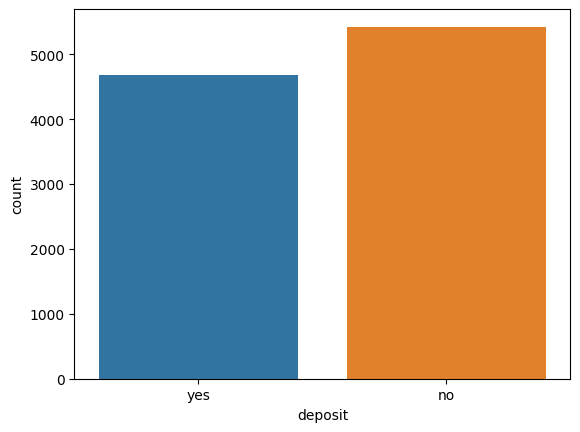

In [16]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
sns.countplot(data=df, x='deposit')

Классы относительно сбалансированы.

In [17]:
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

### Задания 2 и 3

In [18]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [19]:
# проведём замену значений целевого признака deposit на булевые: 1 - 'yes', 0 - 'no'
df['deposit'] = df['deposit'].apply(lambda x:int(1) if x == 'yes' else int(0))

In [20]:
# deposit vs age

fig = px.line(pd.DataFrame(df.groupby('age')['deposit'].sum()).reset_index(), x='age', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от возраста(age)')
fig.show()

Больше всего оформляют депозиты люди в возрасте 28-37 лет, начисная с 60 лет резский скачек в низ, дальше уже медленный спад, хотя начиная с 20 лет резкий скачек вверх

In [21]:
# deposit vs day

fig = px.line(pd.DataFrame(df.groupby('day')['deposit'].sum()).reset_index(), x='day', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от дня месяца(day), в который был последний контакт')
fig.show()

Чаще всего клиенты открывали депозит на 30 день месяца, это логично, все хотели , что бы процент за весь следующий месяц был начислен, так же пиковые дни приходиться на 4,5,13,15 это может быть связано с тем , что люди получали зарплату и открывали депозит, минимальный приток был 24 числа, объяснить возможно, опять таки зарплатой как правило аванс меньше чем зарплата и возможно к этому времени не было денег, а если были проще было подождать до 30 дня , что бы следующий месяц был полным.

In [22]:
# deposit vs duration

fig = px.line(pd.DataFrame(df.groupby('duration')['deposit'].sum()).reset_index(), x='duration', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от продолжительность контакта в секундах(duration)')
fig.show()

Исходя из графика мы видим, что идеальное время 136-300 сек, хот нельзя не обратить внимание на стабильность согласия в количестве 1 депозита по мере увеличения времени разговора, хотя в теории с увеличением времени разговора вероятность согласия должна быть больше.

In [23]:
# deposit vs campaign

fig = px.line(pd.DataFrame(df.groupby('campaign')['deposit'].sum()).reset_index(), x='campaign', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от количество контактов с этим клиентом в течение текущей кампании(campaign)')
fig.show()

Большинство открывают депозит до 5 контактов, дальнейшие увеличение контактов не эффективно

In [24]:
# deposit vs previous

fig = px.line(pd.DataFrame(df.groupby('previous')['deposit'].sum()).reset_index(), x='previous', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от количество контактов до текущей кампании(previous)')
fig.show()

Чем меньше контактов до текущей компании, тем выше шанс , что клиент откроет депозит, это можно объяснить 2 причинами, либо качество контактов плохое, либо клиенты устали от навязывания

### Задания 4 и 5

In [25]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570


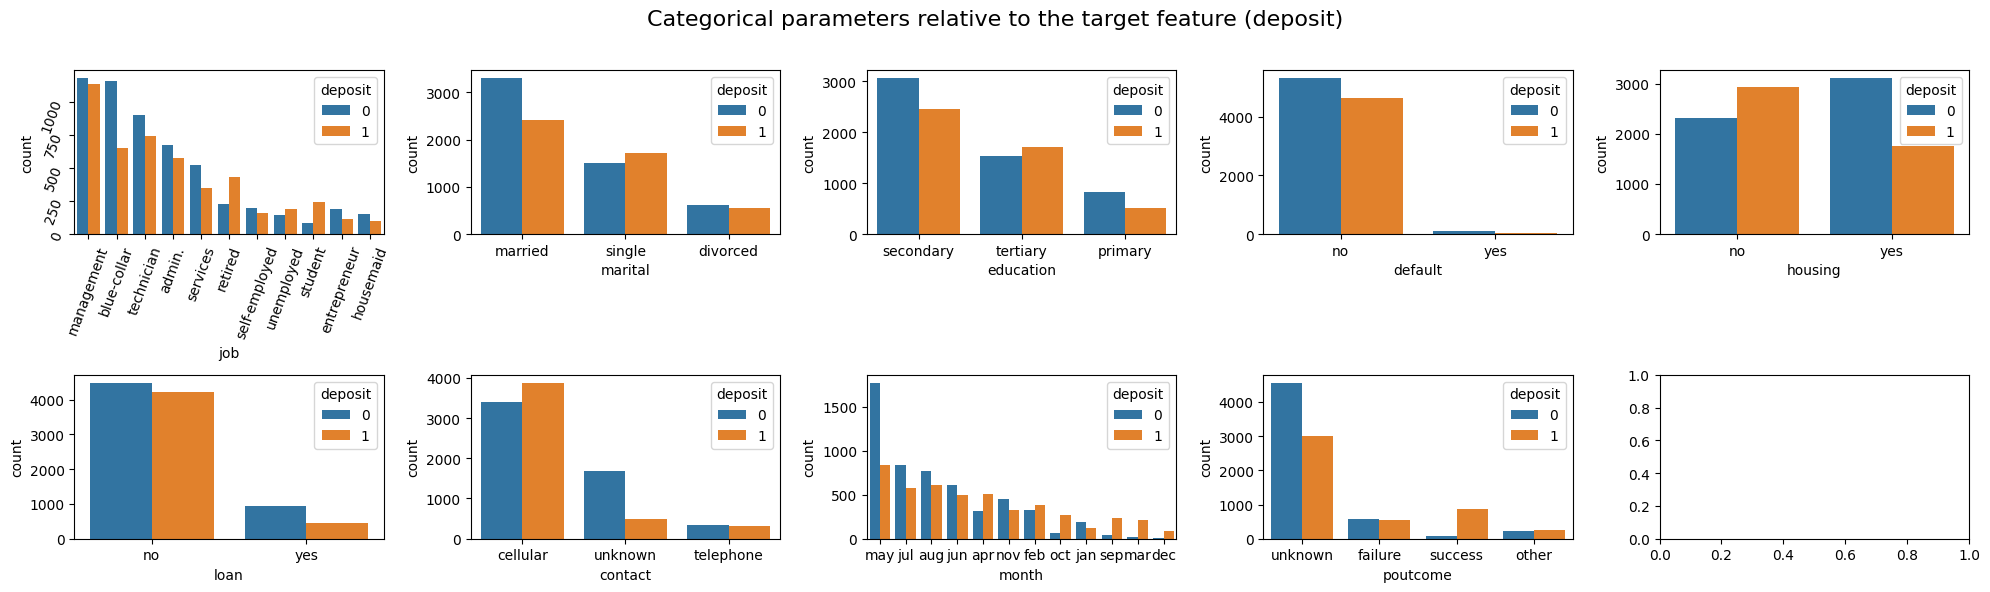

In [26]:
fig, ax = plt.subplots(2,5, figsize=(20,6))

# Сфера занятости
sns.countplot(
    data=df, x='job', hue='deposit', 
    order=df['job'].value_counts().index, ax=ax[0,0])

# Семейное положение
sns.countplot(
    data=df, x='marital', hue='deposit',
    order=df['marital'].value_counts().index, ax=ax[0,1])

# Уровень образования
sns.countplot(
    data=df, x='education', hue='deposit',
    order=df['education'].value_counts().index, ax=ax[0,2])

# Наличие просроченного кредита
sns.countplot(
    data=df, x='default', hue='deposit',
    order=df['default'].value_counts().index, ax=ax[0,3])

# Наличие ипотеки
sns.countplot(
    data=df, x='housing', hue='deposit',
    order=df['housing'].value_counts().index, ax=ax[0,4])

# Наличие потребительского кредита
sns.countplot(
    data=df, x='loan', hue='deposit',
    order=df['loan'].value_counts().index, ax=ax[1,0])

# Тип контакта с клиентом
sns.countplot(
    data=df, x='contact', hue='deposit', 
    order=df['contact'].value_counts().index, ax=ax[1,1])

# Месяц последнего контакта с клиентом
sns.countplot(
    data=df, x='month', hue='deposit',
    order=df['month'].value_counts().index, ax=ax[1,2])

# Результат предыдущей маркетинговой кампании
sns.countplot(
    data=df, x='poutcome', hue='deposit',
    order=df['poutcome'].value_counts().index, ax=ax[1,3])
ax[0,0].tick_params(labelrotation=70)
plt.suptitle(
    'Categorical parameters relative to the target feature (deposit)\n',
    fontsize=16)
plt.tight_layout()

* **Работа**: больше всего открывают депозиты , оно и логично, люди с должности менеджеров, так называемых "голубых воротничков", то есть люди у кого есть , что вкладывать, но стоит так же обратить и на пенсионеров, не смотря на то что они в хороших середнячках по числу депозитов, но они чаще всего дают согласие, как и студенты.

* **Семейное положение**: больше депозитов открывают люди в браке, хотя согласие меньше чем отказов, чего не скажешь об одиноких которые чаще соглашаются открыть чем отказываются, пусть и разница не значительная , но она есть.

* **Образование**: больше всего открывают депозиты, люди со среднее образование, но чаще дают согласие с высшим

* **Наличие просроченного кредита**: при отсутствие пропуска по обязательствам больше открывают депозиты

* **Ипотека**: при наличии ипотеки, денег мало и это естественно, что меньше открывают депозиты и чаще говорят нет при предположении.

* **Потребительский кредит** аналогичная ситуация как и с ипотекой

* **Контакт**: логично, что контакт с клиентом вероятнее по мобильной связи, соответственно там больше шансов получить согласие.

* **Месяцы**: чаще всего соглашались и больше всех отказывали в мае, есть предположение, что в этот месяц было больше всего контактов, так же количество отказов может быть вызвано началом лета, возможно люди собирались отдохнуть, а в остальные месяцы, за исключением лета, количество согласий больше, не смотря на то что общее количество оформленных депозитов летом больше, но это возможно связано именно с количеством контакта с клиентом.

* **Предыдущая маркетинговая компания**: больше согласия, хотя очень много статуса **"unknown"**



### Задание 6

In [27]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby('poutcome')['deposit'].value_counts().unstack()

deposit,0,1
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


### Задание 7

In [28]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df.groupby('month')['deposit'].value_counts().unstack().sort_values(0, ascending=False)

deposit,0,1
month,,
may,1776,841
jul,836,582
aug,775,610
jun,606,498
nov,456,324
feb,323,386
apr,317,513
jan,194,125
oct,62,273


### Задание 8

In [29]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def create_age_group(age):
    if age < 30:
        age_group = '<30'
    elif 30 <= age < 40:
        age_group = '30-40'
    elif 40 <= age < 50:
        age_group = '40-50'
    elif 50 <= age < 60:
        age_group = '50-60'
    else:
        age_group = '60+'
    return age_group

df['age_group'] = df['age'].apply(create_age_group)

In [30]:
fig = px.bar(df.pivot_table(
    values='day',
    index='age_group',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='age_group', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе возрастных групп(age_group)')
fig.show()

Больше всего оформляют депозит люди 40+(потому, что в этом возрасте пик заработков), но чаще соглашаются люди меньше 30 и старше 60(потом, что в этом возрасте больше стремление сохранить)

### Задания 9 и 10

Text(0.5, 1.0, 'Marital status\n')

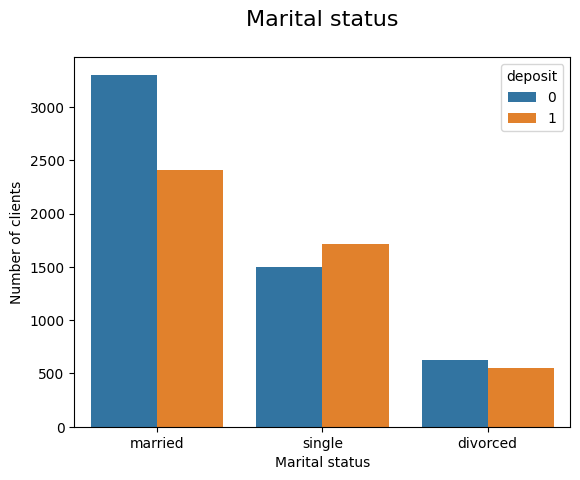

In [31]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

ax = sns.countplot(data=df, x='marital', hue='deposit')
ax.set(xlabel='Marital status', ylabel='Number of clients')
ax.set_title('Marital status\n', fontsize=16)

In [32]:
round((df.groupby('marital')['deposit'].value_counts(normalize=True).unstack() \
    * 100).sort_values(1, ascending=False),2)

deposit,0,1
marital,,
single,46.59,53.41
divorced,53.02,46.98
married,57.80,42.20


Больше дают согласие те кто не был в браке, это обусловлено тем, что не на кого тратить деньги

Text(0.5, 1.0, 'Education\n')

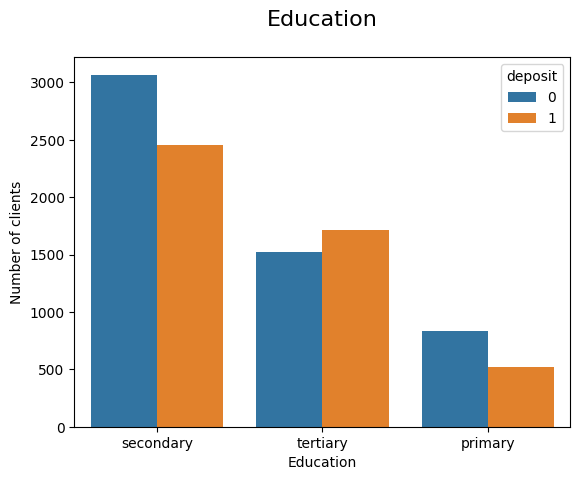

In [33]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

ax = sns.countplot(data=df, x='education', hue='deposit')
ax.set(xlabel='Education', ylabel='Number of clients')
ax.set_title('Education\n', fontsize=16)

Чаще всего дают согласие , те у кого высшее образование

Text(0.5, 1.0, 'Job\n')

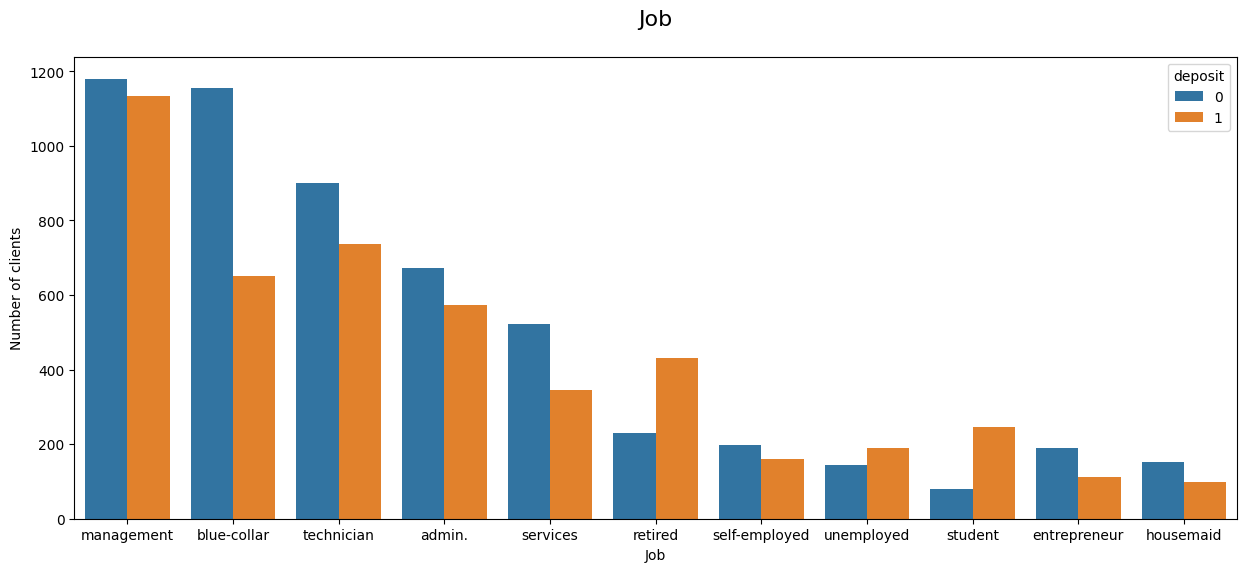

In [34]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

fig, ax = plt.subplots(figsize=(15,6))
ax= sns.countplot(data=df, x='job', hue='deposit', 
              order=df['job'].value_counts().index)
ax.set(xlabel='Job', ylabel='Number of clients')
ax.set_title('Job\n', fontsize=16)

In [35]:
df['job'].value_counts()

management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

In [36]:
round((df.groupby('job')['deposit'].value_counts(normalize=True).unstack() \
    * 100).sort_values(1, ascending=False),2)

deposit,0,1
job,,
student,24.85,75.15
retired,34.84,65.16
unemployed,43.07,56.93
management,50.97,49.03
admin.,53.93,46.07
technician,54.95,45.05
self-employed,55.03,44.97
services,60.25,39.75
housemaid,60.71,39.29


Не смотря на то , что банк чаще взаимодействует с менеджерами, чаще согласие дают студенты и пенсионеры, что подтверждает график по возрасту.

### Задание 11

In [37]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны

round(df.pivot_table(
    values='day',
    index=['education', 'marital'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0)[1]/df.groupby(['education', 'marital'])['deposit'].count() * 100)
#(если рассматривать тех, кто открыл депозит)

education  marital 
primary    divorced    51.0
           married     35.0
           single      45.0
secondary  divorced    43.0
           married     41.0
           single      50.0
tertiary   divorced    52.0
           married     49.0
           single      59.0
dtype: float64

Для тех, кто открыл депозит


marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


Для тех, кто не открыл депозит


marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


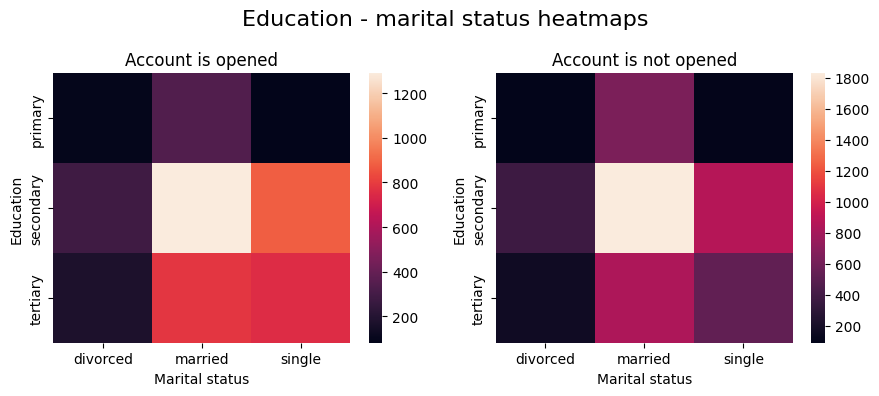

In [38]:
success = df[df['deposit']== 1]
fail = df[df['deposit']== 0]
success_pivot = success.groupby(
    ['education', 'marital'])['marital'].count().unstack()

fail_pivot = fail.groupby(
    ['education', 'marital'])['marital'].count().unstack()

print("Для тех, кто открыл депозит")
display(success_pivot)
print("Для тех, кто не открыл депозит")
display(fail_pivot)

fig, ax = plt.subplots( 1, 2, figsize=(9,4))
sns.heatmap(success_pivot, ax=ax[0])
sns.heatmap(fail_pivot, ax=ax[1])
ax[0].set_title('Account is opened')
ax[1].set_title('Account is not opened')
ax[0].set(xlabel='Marital status', ylabel='Education')
ax[1].set(xlabel='Marital status', ylabel='Education')
plt.suptitle('Education - marital status heatmaps', fontsize=16)
plt.tight_layout()

В обеих категориях (открывшие и неоткрывшие депозит) преобладают семейные клиенты со средним образованием.



## Часть 3: преобразование данных

### Задание 1

In [39]:
# преобразуйте уровни образования
label_encoder = LabelEncoder() # кодируем порядковым кодировщиком
data_educ = label_encoder.fit_transform(df['education'])
df['education_cod'] = data_educ

In [42]:
df['education_cod'].sum()

11995

In [43]:
# преобразуйте возрастные группы
data_age = label_encoder.fit_transform(df['age_group'])
df['age_group'] = data_age

In [45]:
round(df['deposit'].describe(),3)

count    10105.000
mean         0.463
std          0.499
min          0.000
25%          0.000
50%          0.000
75%          1.000
max          1.000
Name: deposit, dtype: float64

### Задания 2 и 3

In [46]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['housing_bin'] = df['housing'].apply(lambda x: int(1) if x == 'yes' else int(0))
df['default_bin'] = df['default'].apply(lambda x: int(1) if x == 'yes' else int(0))
df['loan_bin'] = df['loan'].apply(lambda x: int(1) if x == 'yes' else int(0))

In [50]:
print(round((df['housing_bin'].sum() / df['housing_bin'].shape[0])+(df['default_bin'].sum() / df['default_bin'].shape[0])+(df['loan_bin'].sum() / df['loan_bin'].shape[0]),3))

0.635


### Задание 4

In [51]:
# создайте дамми-переменные
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'], prefix=['job', 'marital', 'contact', 'month', 'poutcome'])
df = df.drop(columns=['age', 'education', 'default', 'loan', 'housing'])

In [53]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10105 entries, 0 to 10104
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   balance            10105 non-null  float64
 1   day                10105 non-null  int64  
 2   duration           10105 non-null  int64  
 3   campaign           10105 non-null  int64  
 4   pdays              10105 non-null  int64  
 5   previous           10105 non-null  int64  
 6   deposit            10105 non-null  int64  
 7   age_group          10105 non-null  int32  
 8   education_cod      10105 non-null  int32  
 9   housing_bin        10105 non-null  int64  
 10  default_bin        10105 non-null  int64  
 11  loan_bin           10105 non-null  int64  
 12  job_admin.         10105 non-null  uint8  
 13  job_blue-collar    10105 non-null  uint8  
 14  job_entrepreneur   10105 non-null  uint8  
 15  job_housemaid      10105 non-null  uint8  
 16  job_management     101

### Задания 5 и 6

In [55]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corrs = round(df.corr(), 2)
fig = px.imshow(
    img=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    text_auto=True,    
    title='Матрица корреляции признаков',
    width=1850,
    height=1500
    )
fig.show()

In [56]:
corrs = round(df.corr(), 2).drop('deposit', axis=0)

fig = px.bar(corrs['deposit'].sort_values(ascending=False),
             x=list(corrs['deposit'].sort_values(ascending=False).index),
             y='deposit',
             text_auto=True,
             title='Ранжирования коэффициентов корреляции'
             )

fig.show()  

Мультиколлинеарность признаков отсутсвует. 

Признаки наиболее коррелирующие с целевой переменной:
- продолжительность контакта в секундах(duration)
- успех результата прошлой маркетинговой кампании(poutcome_success)
- контакт с клиентом по сотовому(contact_cellular)

### Задания 7 и 8

In [57]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [60]:
# рассчитайте необходимые показатели
print(X_test.shape[0], round((y_test.mean()),2))

3335 0.463


### Задание 9

In [61]:
from sklearn.feature_selection import SelectKBest, f_regression

In [62]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()
selector_col = list(selector.get_feature_names_out())
selector_col

['balance',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'housing_bin',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [63]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scal = scaler.fit_transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)
X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, columns=X_test.columns)

In [92]:
round((X_test_scal['balance'].mean()),2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [93]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_model = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_model.fit(X_train_scal, y_train)
y_test_pred = log_model.predict(X_test_scal)
y_train_pred = log_model.predict(X_train_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      1790
           1       0.82      0.77      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.81      0.81      3335
weighted avg       0.82      0.82      0.82      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      3634
           1       0.85      0.80      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770



### Задания 2,3,4

In [94]:
tree_model = tree.DecisionTreeClassifier(random_state=42, criterion='entropy')
tree_model.fit(X_train_scal, y_train)
y_test_pred = tree_model.predict(X_test_scal)
y_train_pred = tree_model.predict(X_train_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.79      0.80      0.80      1790
           1       0.77      0.75      0.76      1545

    accuracy                           0.78      3335
   macro avg       0.78      0.78      0.78      3335
weighted avg       0.78      0.78      0.78      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770



Можно наблюдать после реализации алгоритма и оценки его качества переобучение

Максимальная точность на тесте: 0.817
Оптимальная глубина дерева: 9


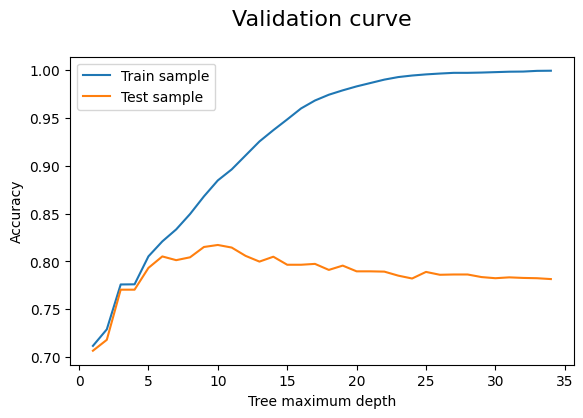

In [95]:
# Перебираем значения max_deph 
# Считаем accuracy на тренировочной и тестовой выборках
train_scores = []
test_scores = []
for max_depth in range(1,35):
    dtree = tree.DecisionTreeClassifier(
        criterion='entropy', random_state=42, max_depth=max_depth)
    dtree.fit(X_train, y_train)
    y_train_pred = dtree.predict(X_train)
    y_test_pred = dtree.predict(X_test)
    train_scores.append(metrics.accuracy_score(y_train, y_train_pred))
    test_scores.append(metrics.accuracy_score(y_test, y_test_pred))
    
# Рисунок
max_depth = list(range(1,35))
fig = plt.figure(figsize=(6.5, 4))
ax = sns.lineplot(x=max_depth, y=train_scores, label='Train sample')
sns.lineplot(x=max_depth, y=test_scores, label='Test sample')
ax.set(xlabel='Tree maximum depth', ylabel='Accuracy')
ax.set_title('Validation curve\n', fontsize=16);

# Оптимальный параметр
print(f'Максимальная точность на тесте: {np.amax(test_scores):.3f}')
print(f'Оптимальная глубина дерева: {np.argmax(test_scores)}')

### Задание 5

In [96]:
# подберите оптимальные параметры с помощью gridsearch

from sklearn.model_selection import GridSearchCV
# задаём сетку параметров
param_grid = [
              {'min_samples_split': [2, 5, 7, 10] , # Минимальное количество выборок, необходимое для разделения внутреннего узла
              'max_depth':[3,5,7] # Максимальная глубина дерева
               }              
]

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy',
        
        random_state=42, #генератор случайных чисел
        ), 
    param_grid=param_grid, 
    n_jobs = -1,
    scoring='f1'
)  

grid_search.fit(X_train_scal, y_train) 
print(f'Best Hyperparameter Values: {grid_search.best_params_}')
print(f'Best Models:{grid_search.best_estimator_}')
print(f'Best score Cross validation: {grid_search.best_score_:.3f}')
y_test_pred = grid_search.predict(X_test_scal)
y_train_pred = grid_search.predict(X_train_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Best Hyperparameter Values: {'max_depth': 7, 'min_samples_split': 10}
Best Models:DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10,
                       random_state=42)
Best score Cross validation: 0.795
Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.81      0.75      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      3634
           1       0.85      0.77      0.81      3136

    accuracy                           0.83      6770
   macro avg       0.83      0.83      0.83      6770
weighted avg       0.83      0.83      0.83      6770



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [97]:
# обучите на ваших данных случайный лес
forest_model = ensemble.RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_leaf=5,
    criterion='gini'
)
forest_model.fit(X_train_scal, y_train)
y_train_pred = forest_model.predict(X_train_scal)
y_test_pred = forest_model.predict(X_test_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1790
           1       0.81      0.86      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      3634
           1       0.85      0.89      0.87      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.88      0.87      6770
weighted avg       0.88      0.87      0.87      6770



### Задания 2 и 3

In [100]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5,
    max_depth=5, random_state=42)
gboost.fit(X_train, y_train)

y_test_pred = gboost.predict(X_test)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.883     0.837     0.859      1790
           1      0.822     0.872     0.846      1545

    accuracy                          0.853      3335
   macro avg      0.853     0.854     0.853      3335
weighted avg      0.855     0.853     0.853      3335



### Задание 4

In [101]:
# объедините уже известные вам алгоритмы с помощью стекинга 
dtree = tree.DecisionTreeClassifier(
    criterion='entropy', max_depth=7, min_samples_split=7, random_state=42)
logregr = linear_model.LogisticRegression(
    solver='sag', max_iter=1000, random_state=42)
gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5, 
    max_depth=5, random_state=42)

estimators = [
    ('dtree', dtree), ('logregr', logregr), ('gboost', gboost)]

stacked = ensemble.StackingClassifier(estimators=estimators)
stacked.fit(X_train, y_train)

y_test_pred = stacked.predict(X_test)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.877     0.845     0.861      1790
           1      0.828     0.862     0.845      1545

    accuracy                          0.853      3335
   macro avg      0.852     0.854     0.853      3335
weighted avg      0.854     0.853     0.853      3335



### Задание 5

In [103]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5, 
    max_depth=5, random_state=42)
gboost.fit(X_train, y_train)
sorted(list(zip(selector_col, gboost.feature_importances_)), 
       key=lambda x: x[1], reverse=True)

[('campaign', 0.45027657258384124),
 ('previous', 0.044986525591326404),
 ('contact_unknown', 0.042915945556279235),
 ('duration', 0.04198529128133664),
 ('housing_bin', 0.031398406399568465),
 ('balance', 0.03008818392065482),
 ('pdays', 0.00874331757859254),
 ('month_may', 0.007347583651170182),
 ('age_group', 0.0056573422102472945),
 ('contact_cellular', 0.0038381614734488913),
 ('month_oct', 0.0012022996938354776),
 ('month_sep', 0.001169085954757298),
 ('poutcome_unknown', 0.0008617900006405829),
 ('poutcome_success', 0.00033389341944757675),
 ('month_mar', 0.00032503268153015545)]

### Задания 6,7,8

In [107]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
# (реализуем для случайного леса)
import optuna
from sklearn.model_selection import cross_val_score

def obj_func(trial):
    # пространство гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42)
    
    # обучаем модель
    model.fit(X_train, y_train)
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1').mean()
    
    return score


# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    sampler=sampler, study_name='RF_Classifier', direction='maximize')
study.optimize(obj_func, n_trials=10)
print(f'Лучшие параметры:\n{study.best_params}')

[I 2023-07-31 20:43:19,281] A new study created in memory with name: RF_Classifier
[I 2023-07-31 20:43:24,322] Trial 0 finished with value: 0.8430328744389934 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8430328744389934.
[I 2023-07-31 20:43:30,704] Trial 1 finished with value: 0.8460975983703861 and parameters: {'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8460975983703861.
[I 2023-07-31 20:43:34,598] Trial 2 finished with value: 0.842340821781281 and parameters: {'n_estimators': 105, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8460975983703861.
[I 2023-07-31 20:43:39,858] Trial 3 finished with value: 0.8382698531969037 and parameters: {'n_estimators': 171, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8460975983703861.
[I 2023-07-31 20:43:46,859] Trial 4 finished with value: 0.843915794176815 and parameters: {'n_estimators

Лучшие параметры:
{'n_estimators': 151, 'max_depth': 22, 'min_samples_leaf': 2}


In [108]:
# Модель с лучшими параметрами  
rf_best = ensemble.RandomForestClassifier(
    **study.best_params, random_state=42)
rf_best.fit(X_train, y_train)
y_test_pred = rf_best.predict(X_test)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.884     0.834     0.858      1790
           1      0.819     0.873     0.845      1545

    accuracy                          0.852      3335
   macro avg      0.851     0.853     0.852      3335
weighted avg      0.854     0.852     0.852      3335



*Общий вывод*

* Проведена предобработка признаков. Простыми способами (медиана, мода) заменены пропущенные значения. Методом Тьюкки удалены выбросы баланса.
* Проведен разведывательный анализ данных в контексте влияния на целевой признак.
* Проведено кодирование признаков и масштабирование значений. Для соответствия ответам на обучающей платформе не соблюдается порядковое кодирование возрастных групп - фактически они маркируются как несвязанные зависимостью классы (Label Encoder). Не проводилась трансформация признаков к нормальному распределению.
* На основе корреляции Кендалла дана оценка влияния признаков на целевой признак (выбрана из-за очевидного отсутствия связи с целевым признаком по монотонной функции, а также ввиду распределений признаков, отличных от нормальных). С помощью ANOVA F-value (f_classif) для построения моделей отобраны 15 наиболее значимых признаков, отобор в целом соответствует результатам по корреляции Кендалла. Попытка отобрать признаки по взаимной информации (mutual_info_classif, не отображено в данном ноутбуке) показала большое несоответствие с оценкой значимости по корреляции Кендалла.
* Построены простые базовые модели - логистическая регрессия и решающее дерево.
* Построены ансамблевые модели - случайный лес, градиентный бустинг на решающих деревьх, стекинг из деревьев, регрессии и бустинга.
* Реализованы примеры подбора гиперпараметров - поиск по сетке, Tree-tructured Parzen estimator (в Optuna).
* На каждом этапе моделирования оценивались метрики качества классификации. Ансамблевые решения закономерно показывают лучшие значения. Какая либо качественная разница между ансамблевыми моделями на данном датасете не прослеживается. Подбор гиперпараметров модели случайного леса незначительно, на десятые доли процента, улучшил результат.
* Задача решена на базовом уровне в соответствии с минимумом требований, необходимых для сдачи проекта. Безусловно остается потенциал по возможному улучшению метрик при более тщательной и творческой обработке признаков, транформации данных, экспериментировании с различными моделями.